In [2]:
import gym
import joblib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

import threading

from breakout import make_breakout

In [50]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K

In [4]:
env = make_breakout()
n_actions = env.action_space.n
t_local = threading.local()

[2017-04-13 20:03:30,162] Making new env: BreakoutDeterministic-v0


In [5]:
def reshape_frame(frame):
    """
    Convert (4,64,64) into (64, 256)
    """
    return frame.swapaxes(1,2).reshape(-1,64).T

In [86]:
def make_model(n_actions, beta=0.1):
    in_t = Input(shape=(64, 256), name="in")
    out_t = Reshape((64, 256, 1), name="reshape")(in_t)
    out_t = Conv2D(32, (5, 5), activation='relu', padding='same')(out_t)
    out_t = MaxPooling2D((2, 2))(out_t)
    out_t = Conv2D(32, (5, 5), activation='relu', padding='same')(out_t)
    out_t = MaxPooling2D((2, 2))(out_t)
    out_t = Conv2D(64, (4, 4), activation='relu', padding='same')(out_t)
    out_t = MaxPooling2D((2, 2))(out_t)
    out_t = Conv2D(64, (3, 3), activation='relu', padding='same')(out_t)
    out_t = Flatten(name='flat')(out_t)
    out_t = Dense(512, name='l1', activation='relu')(out_t)
    policy_t = Dense(n_actions, name='policy', activation='softmax')(out_t)
    
    def entropy_loss_func(p_t):
        log_p_t = K.log(p_t + K.epsilon())
        return beta * K.sum(p_t * log_p_t, axis=-1, keepdims=True)

    entropy_t = Lambda(entropy_loss_func, name="entropy", output_shape=(1,))(policy_t)
    
    return Model(inputs=in_t, outputs=[policy_t, entropy_t])

In [87]:
model = make_model(n_actions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 64, 256)           0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 256, 1)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 256, 32)       832       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 128, 32)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 128, 32)       25632     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 64, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 64, 64)        32832     
__________

In [88]:
def build_session_chunk(env, model, chunk_len):
    s = env.s
    
    if not hasattr(env, "session_reward"):
        env.session_reward = 0
        env.session_steps = 0
    s_reward = env.session_reward
    s_steps = env.session_steps
    
    total_reward = 0
    states, actions = [], []
    
    for _ in range(chunk_len):
        reshaped_s = reshape_frame(s)
        probs = model.predict_on_batch(np.array([reshaped_s]))[0][0]
        action = np.random.choice(n_actions, p=probs)
        
        states.append(reshaped_s)
        actions.append(action)
        s, r, done, _ = env.step(action)
        total_reward += r
        s_reward += r
        s_steps += 1
        
        if done:
#            print("Env done after %d steps, %d total reward" % (s_steps, s_reward))
            s = env.reset()
            s_reward = 0
            s_steps = 0
    env.s = s
    env.session_reward = s_reward
    env.session_steps = s_steps
    
    return states, actions, total_reward

In [89]:
losses = {
    'policy': 'categorical_crossentropy',
    'entropy': lambda y_true, y_pred: y_pred,
}

In [90]:
model.compile(optimizer=Adam(lr=0.001, epsilon=1e-3, clipnorm=0.1), loss=losses)

In [91]:
percentille = 50
mean_rewards = []
thresholds = []
losses = []
losses_entropy = []
n_iterations = 100
n_envs = 10

envs = [make_breakout() for _ in range(n_envs)]
# store last state inside env itself
for e in envs:
    e.s = e.reset()

[2017-04-13 22:56:17,722] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,740] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,758] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,776] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,793] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,810] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,828] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,847] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,864] Making new env: BreakoutDeterministic-v0
[2017-04-13 22:56:17,881] Making new env: BreakoutDeterministic-v0


In [107]:
n_iterations = 1000

In [108]:
for idx in tqdm(range(n_iterations)):
    data = [build_session_chunk(e, model, 100) for e in envs] 
    states, actions, rewards = map(np.array, zip(*data))
    threshold = np.percentile(rewards, percentille)

    elite_states = states[rewards > threshold]
    elite_actions = actions[rewards > threshold]

    m_reward = np.mean(rewards)
    mean_rewards.append(m_reward)
    thresholds.append(threshold)

    if elite_actions.size == 0:
        print("No elite actions, skip")
    else:
        elite_states = np.concatenate(elite_states)
        elite_actions = np.concatenate(elite_actions)
        elite_one_hot = to_categorical(elite_actions, n_actions)
        l = model.train_on_batch(elite_states, [elite_one_hot]*2)
        losses.append(l[0])
        losses_entropy.append(l[-1])
        print("%d: mean reward %.2f, threshold %.2f, loss %.4f, count %d" % (
            idx, m_reward, threshold, l[0], (rewards > threshold).sum()))

0: mean reward 1.00, threshold 1.00, loss 1.6124, count 2
1: mean reward 0.80, threshold 1.00, loss 1.6132, count 1
2: mean reward 0.90, threshold 1.00, loss 1.6097, count 1
3: mean reward 0.90, threshold 1.00, loss 1.6112, count 1
4: mean reward 0.90, threshold 0.50, loss 1.6068, count 5
5: mean reward 1.10, threshold 1.00, loss 1.6052, count 3
6: mean reward 0.50, threshold 0.00, loss 1.6129, count 3
7: mean reward 0.80, threshold 1.00, loss 1.6148, count 1
8: mean reward 0.60, threshold 0.00, loss 1.6112, count 4
9: mean reward 1.00, threshold 1.00, loss 1.6089, count 2
10: mean reward 1.10, threshold 1.50, loss 1.6135, count 5
11: mean reward 0.60, threshold 0.50, loss 1.6138, count 5
12: mean reward 0.60, threshold 0.50, loss 1.6074, count 5
13: mean reward 1.00, threshold 1.00, loss 1.6092, count 3
14: mean reward 0.50, threshold 0.50, loss 1.6136, count 5
15: mean reward 0.90, threshold 1.00, loss 1.6138, count 2
16: mean reward 0.80, threshold 0.50, loss 1.6104, count 5
17: mea

147: mean reward 0.70, threshold 0.50, loss 1.6119, count 5
148: mean reward 1.00, threshold 1.00, loss 1.6068, count 2
149: mean reward 0.80, threshold 1.00, loss 1.6120, count 2
150: mean reward 0.70, threshold 1.00, loss 1.6015, count 1
151: mean reward 1.20, threshold 1.50, loss 1.6097, count 5
152: mean reward 0.70, threshold 0.50, loss 1.6139, count 5
153: mean reward 0.40, threshold 0.00, loss 1.6107, count 4
154: mean reward 0.80, threshold 1.00, loss 1.6112, count 1
155: mean reward 0.80, threshold 1.00, loss 1.6115, count 2
156: mean reward 0.70, threshold 0.50, loss 1.6124, count 5
157: mean reward 1.10, threshold 1.00, loss 1.6083, count 3
158: mean reward 0.70, threshold 0.50, loss 1.6131, count 5
159: mean reward 0.50, threshold 0.00, loss 1.6074, count 4
160: mean reward 1.20, threshold 1.00, loss 1.6114, count 3
161: mean reward 0.40, threshold 0.00, loss 1.6057, count 4
162: mean reward 1.10, threshold 1.00, loss 1.6108, count 2
163: mean reward 0.90, threshold 1.00, l

287: mean reward 1.20, threshold 1.00, loss 1.5989, count 4
288: mean reward 0.80, threshold 1.00, loss 1.6018, count 2
289: mean reward 1.00, threshold 1.00, loss 1.6054, count 4
290: mean reward 1.10, threshold 1.00, loss 1.6110, count 2
No elite actions, skip
No elite actions, skip
293: mean reward 1.50, threshold 2.00, loss 1.5818, count 1
294: mean reward 0.50, threshold 0.50, loss 1.6145, count 5
295: mean reward 0.90, threshold 1.00, loss 1.6068, count 2
296: mean reward 0.90, threshold 1.00, loss 1.6098, count 1
297: mean reward 0.70, threshold 1.00, loss 1.6225, count 1
298: mean reward 0.90, threshold 1.00, loss 1.6051, count 2
299: mean reward 0.70, threshold 1.00, loss 1.6101, count 1
300: mean reward 1.20, threshold 1.00, loss 1.5909, count 2
301: mean reward 1.20, threshold 1.00, loss 1.6007, count 2
302: mean reward 0.80, threshold 1.00, loss 1.6065, count 1
303: mean reward 1.00, threshold 1.00, loss 1.6124, count 2
304: mean reward 1.10, threshold 1.00, loss 1.6036, co

429: mean reward 1.10, threshold 1.00, loss 1.6184, count 3
430: mean reward 1.00, threshold 1.00, loss 1.6063, count 2
431: mean reward 0.90, threshold 1.00, loss 1.5955, count 3
432: mean reward 1.10, threshold 1.00, loss 1.6053, count 3
433: mean reward 1.00, threshold 1.00, loss 1.6110, count 2
434: mean reward 1.00, threshold 1.00, loss 1.6073, count 2
435: mean reward 1.10, threshold 1.00, loss 1.6086, count 2
436: mean reward 1.30, threshold 1.50, loss 1.6080, count 5
437: mean reward 1.00, threshold 1.00, loss 1.6035, count 2
No elite actions, skip
439: mean reward 1.20, threshold 1.00, loss 1.6129, count 2
440: mean reward 0.80, threshold 1.00, loss 1.6053, count 1
441: mean reward 0.60, threshold 0.50, loss 1.6095, count 5
No elite actions, skip
443: mean reward 0.80, threshold 0.50, loss 1.6047, count 5
444: mean reward 0.60, threshold 0.50, loss 1.6113, count 5
445: mean reward 1.20, threshold 1.00, loss 1.6013, count 4
446: mean reward 0.70, threshold 1.00, loss 1.6052, co

572: mean reward 0.90, threshold 1.00, loss 1.5974, count 2
573: mean reward 1.10, threshold 1.00, loss 1.5809, count 4
574: mean reward 0.50, threshold 0.00, loss 1.5935, count 4
575: mean reward 1.30, threshold 1.00, loss 1.5904, count 3
576: mean reward 0.90, threshold 1.00, loss 1.5960, count 3
577: mean reward 1.20, threshold 1.50, loss 1.5949, count 5
578: mean reward 1.00, threshold 1.00, loss 1.6170, count 2
579: mean reward 1.20, threshold 1.00, loss 1.5935, count 3
580: mean reward 1.30, threshold 1.50, loss 1.5948, count 5
581: mean reward 0.90, threshold 1.00, loss 1.5997, count 3
582: mean reward 0.90, threshold 1.00, loss 1.6045, count 2
No elite actions, skip
No elite actions, skip
585: mean reward 1.20, threshold 1.00, loss 1.6044, count 4
586: mean reward 1.00, threshold 1.00, loss 1.5969, count 4
587: mean reward 1.00, threshold 1.00, loss 1.5992, count 2
588: mean reward 1.20, threshold 1.00, loss 1.5911, count 3
589: mean reward 0.90, threshold 1.00, loss 1.5917, co

715: mean reward 1.00, threshold 1.00, loss 1.5722, count 2
716: mean reward 0.90, threshold 1.00, loss 1.5879, count 3
717: mean reward 1.00, threshold 1.00, loss 1.5865, count 3
718: mean reward 0.60, threshold 0.50, loss 1.5951, count 5
719: mean reward 1.20, threshold 1.00, loss 1.5948, count 4
720: mean reward 0.80, threshold 1.00, loss 1.5757, count 1
721: mean reward 1.20, threshold 1.00, loss 1.5681, count 2
No elite actions, skip
723: mean reward 1.30, threshold 1.00, loss 1.5832, count 4
724: mean reward 1.10, threshold 1.00, loss 1.5839, count 3
725: mean reward 1.20, threshold 1.00, loss 1.5761, count 3
726: mean reward 0.80, threshold 1.00, loss 1.5616, count 2
727: mean reward 1.00, threshold 1.00, loss 1.5795, count 2
728: mean reward 1.30, threshold 1.00, loss 1.5786, count 3
729: mean reward 1.20, threshold 1.00, loss 1.5932, count 3
730: mean reward 0.90, threshold 1.00, loss 1.5924, count 2
731: mean reward 0.70, threshold 0.50, loss 1.5993, count 5
732: mean reward 

859: mean reward 0.90, threshold 1.00, loss 1.5975, count 2
860: mean reward 1.30, threshold 1.00, loss 1.5931, count 4
861: mean reward 0.90, threshold 1.00, loss 1.6037, count 2
862: mean reward 1.20, threshold 1.00, loss 1.6008, count 4
863: mean reward 1.10, threshold 1.00, loss 1.6049, count 2
864: mean reward 0.90, threshold 1.00, loss 1.6172, count 1
No elite actions, skip
866: mean reward 0.80, threshold 1.00, loss 1.5850, count 2
867: mean reward 0.80, threshold 1.00, loss 1.5985, count 2
868: mean reward 0.80, threshold 1.00, loss 1.5937, count 2
869: mean reward 1.10, threshold 1.00, loss 1.6004, count 3
870: mean reward 0.60, threshold 0.50, loss 1.5912, count 5
871: mean reward 0.80, threshold 1.00, loss 1.5936, count 2
872: mean reward 0.80, threshold 1.00, loss 1.5882, count 1
873: mean reward 1.40, threshold 1.00, loss 1.5970, count 4
874: mean reward 1.10, threshold 1.00, loss 1.6065, count 2
875: mean reward 0.80, threshold 1.00, loss 1.5968, count 2
876: mean reward 

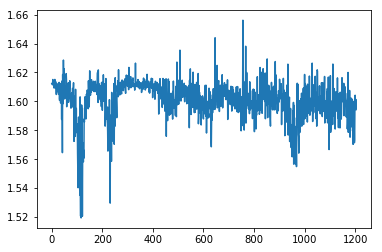

In [109]:
plt.plot(losses)

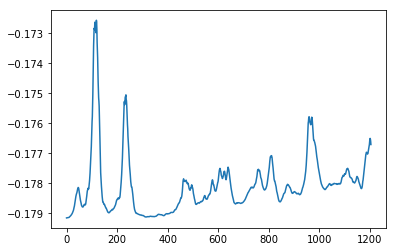

In [110]:
plt.plot(losses_entropy)

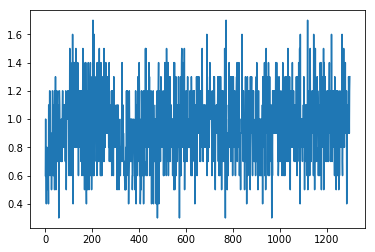

In [111]:
plt.plot(mean_rewards)

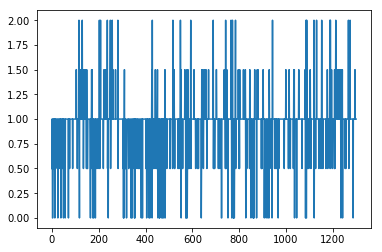

In [112]:
plt.plot(thresholds)